### Agregação de dados e operações em grupos

Classificar um conjunto de dados e aplicar uma função a cada
grupo, seja uma agregação ou uma transformação, com frequência
é um componente essencial em um fluxo de trabalho de análise de
dados. Após carregar, mesclar e preparar um conjunto de dados,
talvez seja necessário calcular estatísticas de grupos ou,
possivelmente, *tabelas pivôs* visando a relatórios e visualizações. O
pandas oferece uma interface flexível groupby , que permite manipular
e resumir conjuntos de dados de forma natural.

Um dos motivos para a popularidade dos bancos de dados
relacionais e do SQL (que quer dizer “Structured Query Language”,
ou Linguagem de Consulta Estruturada) é a facilidade com a qual os
dados podem ser unidos, filtrados, transformados e agregados. No
entanto, as linguagens de consulta como SQL, de certo modo, são
limitadas quanto aos tipos de operações em grupo que podem
executar. Conforme veremos, com a expressividade de Python e do
pandas, podemos executar operações bem complexas em grupos
utilizando qualquer função que aceite um objeto do pandas ou um
array NumPy. Neste capítulo, você aprenderá a:

- separar um objeto do pandas em partes usando uma ou mais
chaves (na forma de funções, arrays ou nomes de colunas de um
DataFrame);
- calcular estatísticas de resumo para grupos, como contador,
média ou desvio-padrão, ou aplicar uma função definida pelo
usuário;
- aplicar transformações em grupos ou fazer outras manipulações
como normalização, regressão linear, classificação ou seleção de
subconjuntos;
- calcular tabelas pivôs e tabulações cruzadas;
- fazer análise de quantis e outras análises estatísticas de grupos.



### Funcionamento de GroupBy

Hadley Wickham, autor de vários pacotes bem populares para a
linguagem de programação R, cunhou o termo *separar-aplicar-combinar*
(split-apply-combine) para descrever operações de grupo. Na
primeira etapa do processo, os dados contidos em um objeto do
pandas, seja uma Series, um DataFrame ou algo diferente, são
*separados* (split) em grupos, com base em uma ou mais *chaves*
especificadas por você. A separação é feita em um eixo em
particular de um objeto. Por exemplo, um DataFrame pode ser
agrupado com base em suas linhas (*axis=0*) ou suas colunas (*axis=1*).
Depois disso, uma função é *aplicada* (apply) em cada grupo, gerando
um novo valor. Por fim, os resultados de todas essas aplicações de
função são *combinados* (combine) formando um objeto resultante. O
formato desse objeto em geral dependerá do que está sendo feito
com os dados. Veja a Figura Abaixo que apresenta um esquema de
uma agregação simples em grupos.

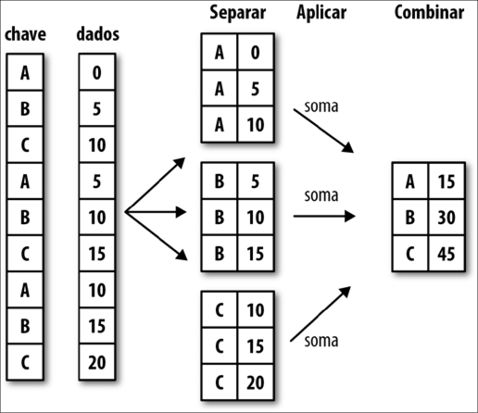

Cada chave de grupo pode assumir diversas formas, e as chave não
precisam ser todas do mesmo tipo:

- uma lista ou um array de valores de mesmo tamanho que o eixo
sendo agrupado;
- um valor indicando um nome de coluna em um DataFrame;
- um dicionário ou uma Series especificando uma correspondência
entre os valores do eixo sendo agrupado e os nomes dos grupos;
- uma função a ser chamada no índice do eixo ou os rótulos
individuais no índice.

Observe que os últimos três métodos são atalhos para gerar um
array de valores a ser usado para separar o objeto. Não se
preocupe se tudo isso parecer abstrato demais. No decorrer deste
capítulo, apresentarei vários exemplos de todos esses métodos.
Para começar, eis um pequeno conjunto de dados tabular na forma
de um DataFrame:

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.DataFrame({'key1': ['a', 'a', 'b', 'b', 'a'],
                   'key2': ['one', 'two', 'one', 'two', 'one'],
                   'data1': np.random.randn(5),
                   'data2': np.random.randn(5)})
df

,key1,key2,data1,data2
0,a,one,-1.160845,0.387606
1,a,two,0.009788,-0.180024
2,b,one,-1.727731,2.211415
3,b,two,-0.467590,-0.159220
4,a,one,0.369067,-0.123913


Suponha que quiséssemos calcular a média da coluna *data1* usando
os rótulos de *key1*. Há várias maneiras de fazer isso. Uma delas é
acessar *data1* e chamar groupby com a coluna (uma Series) em *key1*:

In [ ]:
grouped = df['data1'].groupby(df['key1'])
grouped

Essa variável *grouped* agora é um objeto *GroupBy*. Na verdade, nada
ainda foi calculado, exceto alguns dados intermediários sobre a
chave de grupo *df['key1']*. A ideia é que esse objeto tenha todas as
informações necessárias para então aplicar alguma operação em
cada um dos grupos. Por exemplo, para calcular as médias dos
grupos, podemos chamar o método *mean* de GroupBy:

In [ ]:
grouped.mean()

key1
a   -0.260663
b   -1.097660
Name: data1, dtype: float64

Mais adiante, explicarei melhor o que acontece quando chamamos
*.mean()*. O aspecto importante, nesse caso, é que os dados (uma
Series) foram agregados de acordo com a chave de grupo, gerando
uma nova Series, que agora está indexada pelos valores únicos da
coluna *key1*. O índice resultante recebe o nome *'key1'* por causa da
coluna *df['key1']* do DataFrame.

Se, em vez disso, tivéssemos passado vários arrays na forma de
uma lista, obteríamos um resultado diferente:

In [ ]:
means = df['data1'].groupby([df['key1'], df['key2']]).mean()
means

key1  key2
a     one    -0.395889
      two     0.009788
b     one    -1.727731
      two    -0.467590
Name: data1, dtype: float64

Nesse caso, agrupamos os dados usando duas chaves, e a Series
resultante agora tem um índice hierárquico constituído dos pares de
chave únicos observados:

In [ ]:
means.unstack()

key2,one,two
key1,,
a,-0.395889,0.009788
b,-1.727731,-0.467590


No exemplo a seguir, todas as chaves de grupo são Series, embora
pudessem ser qualquer array do tamanho correto:

In [ ]:
states = np.array(['Ohio', 'California', 'California', 'Ohio', 'Ohio'])
years = np.array([2005, 2005, 2006, 2005, 2006])

In [ ]:
df['data1'].groupby([states, years]).mean()

California  2005    0.009788
            2006   -1.727731
Ohio        2005   -0.814217
            2006    0.369067
Name: data1, dtype: float64

Com frequência, as informações de agrupamento se encontram no
mesmo DataFrame em que estão os dados com os quais você quer
trabalhar. Nesse caso, é possível passar os nomes das colunas
(sejam elas strings, números ou outros objetos Python) como as
chaves de grupo:

In [ ]:
df.groupby('key1').mean()

,data1,data2
key1,,
a,-0.260663,0.027890
b,-1.097660,1.026098


In [ ]:
df.groupby(['key1', 'key2']).mean()

data1     data2
key1 key2                    
a    one  -0.395889  0.131847
     two   0.009788 -0.180024
b    one  -1.727731  2.211415
     two  -0.467590 -0.159220

Talvez você tenha percebido que, no primeiro caso com
*df.groupby('key1').mean()*, não há nenhuma coluna *key2* no resultado.
Como *df['key2']* não é um dado numérico, dizemos que é uma *coluna
inconveniente* (nuisance column) e, desse modo, é excluída do
resultado. Por padrão, todas as colunas numéricas são agregadas,
embora seja possível filtrar e obter um subconjunto, como veremos
em breve.

Independentemente do objetivo visado ao usar *groupby*, um método
em geral útil de GroupBy é *size*, que devolve uma Series contendo
os tamanhos dos *grupos*:

In [ ]:
df.groupby(['key1', 'key2']).size()

key1  key2
a     one     2
      two     1
b     one     1
      two     1
dtype: int64

### Iterando por grupos

O objeto GroupBy aceita iteração, gerando uma sequência de tuplas
de 2 contendo o nome do grupo, junto com a porção de dados.
Considere o seguinte:

In [ ]:
for name, group in df.groupby('key1'):
  print(name)
  print(group)

a
  key1 key2     data1     data2
0    a  one -1.160845  0.387606
1    a  two  0.009788 -0.180024
4    a  one  0.369067 -0.123913
b
  key1 key2     data1     data2
2    b  one -1.727731  2.211415
3    b  two -0.467590 -0.159220


No caso de várias chaves, o primeiro elemento da tupla será uma
tupla de valores de chaves:

In [ ]:
for (k1, k2), group in df.groupby(['key1', 'key2']):
  print((k1, k2))
  print(group)

('a', 'one')
  key1 key2     data1     data2
0    a  one -1.160845  0.387606
4    a  one  0.369067 -0.123913
('a', 'two')
  key1 key2     data1     data2
1    a  two  0.009788 -0.180024
('b', 'one')
  key1 key2     data1     data2
2    b  one -1.727731  2.211415
('b', 'two')
  key1 key2    data1    data2
3    b  two -0.46759 -0.15922


É claro que você pode optar por fazer o que quiser com as porções
de dados. Uma receita que talvez seja útil é gerar um dicionário de
porções de dados usando uma só linha de código:

In [ ]:
pieces = dict(list(df.groupby('key1')))

In [ ]:
pieces['b']

,key1,key2,data1,data2
2,b,one,-1.727731,2.211415
3,b,two,-0.467590,-0.159220


In [ ]:
pieces['a']

,key1,key2,data1,data2
0,a,one,-1.160845,0.387606
1,a,two,0.009788,-0.180024
4,a,one,0.369067,-0.123913


In [ ]:
grouped = df.groupby(df.dtypes, axis=1)

Podemos exibir os grupos da seguinte maneira:

In [ ]:
for dtype, group in grouped:
  print(dtype)
  print(group)

float64
      data1     data2
0 -1.160845  0.387606
1  0.009788 -0.180024
2 -1.727731  2.211415
3 -0.467590 -0.159220
4  0.369067 -0.123913
object
  key1 key2
0    a  one
1    a  two
2    b  one
3    b  two
4    a  one


### Selecionando uma coluna ou um subconjunto de colunas

Indexar um objeto GroupBy criado a partir de um DataFrame com
um nome de coluna ou um array de nomes de coluna tem o efeito
de criar subconjuntos de colunas para agregação. Isso significa que:

In [ ]:
df.groupby('key1')['data1']
df.groupby('key1')[['data2']]

são uma sintax sugar para:


In [ ]:
df['data1'].groupby(df['key1'])
df[['data2']].groupby(df['key1'])

Particularmente para conjuntos grandes de dados, fazer agregações
somente de algumas colunas pode ser desejável. Por exemplo, no
conjunto de dados anterior, para calcular as médias apenas da
coluna data2 e obter o resultado na forma de um DataFrame,
poderíamos escrever o seguinte:

In [ ]:
df.groupby(['key1', 'key2'])[['data2']].mean()

data2
key1 key2          
a    one   0.131847
     two  -0.180024
b    one   2.211415
     two  -0.159220

O objeto devolvido por essa operação de indexação é um
DataFrame agrupado se uma lista ou um array for passado ou uma
Series agrupada se um único nome de coluna for passado como um
escalar:

In [ ]:
s_grouped = df.groupby(['key1', 'key2'])['data2']
s_grouped

In [ ]:
s_grouped.mean()

key1  key2
a     one     0.131847
      two    -0.180024
b     one     2.211415
      two    -0.159220
Name: data2, dtype: float64

### Agrupando com dicionários e Series
Informações de agrupamento podem existir em uma forma que não
seja um array. Vamos considerar outro DataFrame como exemplo:

In [ ]:
people = pd.DataFrame(np.random.randn(5, 5),
                      columns=['a', 'b', 'c', 'd', 'e'],
                      index=['Joe', 'Steve', 'Wes', 'Jim', 'Travis'])

In [ ]:
people

,a,b,c,d,e
Joe,1.158232,0.582836,0.813517,-0.880207,0.129964
Steve,0.302052,1.545203,-1.277122,0.316489,0.075289
Wes,0.422400,-0.553617,0.523880,1.390984,-1.772903
Jim,-0.372091,-1.485772,0.135299,0.395531,-1.330509
Travis,0.080839,-0.023745,0.075764,0.298136,-1.305614


In [ ]:
#          linha coluna
people.iloc[2:3, [1, 2]] = np.nan 

In [ ]:
people

,a,b,c,d,e
Joe,1.158232,0.582836,0.813517,-0.880207,0.129964
Steve,0.302052,1.545203,-1.277122,0.316489,0.075289
Wes,0.422400,NaN,NaN,1.390984,-1.772903
Jim,-0.372091,-1.485772,0.135299,0.395531,-1.330509
Travis,0.080839,-0.023745,0.075764,0.298136,-1.305614


Suponha agora que haja uma correspondência de grupos para as
colunas e queremos somá-las por grupo:

In [ ]:
mapping = {'a': 'red', 'b': 'red', 'c': 'blue',
           'd': 'blue', 'e': 'red', 'f': 'orange'}

Poderíamos construir um array a partir desse dicionário e passá-lo
para *groupby*, mas, em vez disso, podemos simplesmente passar o
dicionário (incluí a chave *'f'* para enfatizar que chaves de
agrupamento não usadas não são um problema):

In [ ]:
by_column = people.groupby(mapping, axis=1)

In [ ]:
by_column.sum()

,blue,red
Joe,-0.066690,1.871032
Steve,-0.960633,1.922543
Wes,1.390984,-1.350503
Jim,0.530830,-3.188372
Travis,0.373900,-1.248521


A mesma funcionalidade vale para Series, que pode ser vista como
um mapeamento de tamanho fixo:

In [ ]:
map_series = pd.Series(mapping)
map_series

a       red
b       red
c      blue
d      blue
e       red
f    orange
dtype: object

In [ ]:
people.groupby(map_series, axis=1).count()

,blue,red
Joe,2,3
Steve,2,3
Wes,1,2
Jim,2,3
Travis,2,3


### Agrupando com funções

Usar funções Python é uma forma mais genérica de definir um
mapeamento de grupos, em comparação com um dicionário ou uma
Series. Qualquer função passada como uma chave de grupo será
chamada uma vez por valor de índice, com os valores de retorno
usados como os nomes dos grupos. De modo mais concreto,
considere o DataFrame de exemplo da seção anterior, que tem os
primeiros nomes das pessoas como valores de índice. Suponha que
quiséssemos agrupar pelo tamanho dos nomes; embora
pudéssemos calcular um array de tamanhos de strings, será mais fácil simplesmente passar a função *len*:

In [ ]:
people.groupby(len).sum()

,a,b,c,d,e
3,1.208541,-0.902935,0.948816,0.906307,-2.973448
5,0.302052,1.545203,-1.277122,0.316489,0.075289
6,0.080839,-0.023745,0.075764,0.298136,-1.305614


Misturar funções com arrays, dicionários ou Series não é um
problema, pois tudo será convertido para arrays internamente:

In [ ]:
key_list = ['one', 'one', 'one', 'two', 'two']

In [ ]:
people.groupby([len, key_list]).min()

a         b         c         d         e
3 one  0.422400  0.582836  0.813517 -0.880207 -1.772903
  two -0.372091 -1.485772  0.135299  0.395531 -1.330509
5 one  0.302052  1.545203 -1.277122  0.316489  0.075289
6 two  0.080839 -0.023745  0.075764  0.298136 -1.305614

### Agrupando por níveis de índice

Um último recurso conveniente para conjuntos de dados
hierarquicamente indexados é a capacidade de agregar usando um
dos níveis de índice de um eixo. Vamos observar um exemplo:

In [ ]:
columns = pd.MultiIndex.from_arrays([['US', 'US', 'US', 'JP', 'JP'],
                                     [1, 3, 5, 1, 3]],
                                    names=['cty', 'tenor'])

In [ ]:
columns

MultiIndex([('US', 1),
            ('US', 3),
            ('US', 5),
            ('JP', 1),
            ('JP', 3)],
           names=['cty', 'tenor'])

In [ ]:
hier_df = pd.DataFrame(np.random.randn(4, 5), columns=columns)

In [ ]:
hier_df

cty          US                            JP          
tenor         1         3         5         1         3
0      0.674554  1.225541 -1.442255  1.482037 -1.388749
1     -0.251828  0.601718  1.041394 -0.202445  0.991284
2      0.498508  0.069813  1.932842  1.289108  1.751797
3      0.196548 -1.008035 -0.394473 -1.429579 -0.654127

Para agrupar por nível, passe o número ou o nome do nível usando
o argumento nomeado level :

In [ ]:
hier_df.groupby(level='cty', axis=1).count()

cty,JP,US
0,2,3
1,2,3
2,2,3
3,2,3


### Agregação de dados
As agregações referem-se a qualquer transformação de dados que
gere valores escalares a partir de arrays. Os exemplos anteriores
usaram várias delas, incluindo *mean , count , min* e *sum* . Talvez você
esteja se perguntando o que acontece quando chamamos *mean()* em
um objeto GroupBy. Muitas agregações comuns, como aquelas que
se encontram na Tabela Abaixo, têm implementações otimizadas.
Contudo não estamos limitados a apenas esse conjunto de
métodos.

### Tabela – Métodos otimizados de groupby

Nome da função | Descrição 
---------------|------------------------------------
**count** | Número de valores diferentes de NA no grupo
**sum** | Soma dos valores diferentes de NA
**mean** | Média dos valores diferentes de NA
**median** | Mediana aritmética dos valores diferentes de NA
**std, var** | Desvio-padrão não tendencioso (denominador n – 1) e
|variância
**min, max** | Mínimo e máximo entre os valores diferentes de NA
**prod** | Produto dos valores diferentes de NA
**first, last** | Primeiro e último dos valores diferentes de NA

Você pode usar agregações definidas por você mesmo e, além
disso, chamar qualquer método que também esteja definido no
objeto agrupado. Por exemplo, talvez você se lembre de que *quantile* calcula os quantis de amostragem em uma Series ou em colunas de
um DataFrame.

Embora *quantile* não seja explicitamente implementado para
GroupBy, é um método de Series e, desse modo, está disponível
para ser usado. Internamente, GroupBy fatia a Series de modo
eficiente, chama *piece.quantile(0.9)* para cada parte e então reúne os
resultados no objeto resultante:

In [ ]:
df

,key1,key2,data1,data2
0,a,one,-1.160845,0.387606
1,a,two,0.009788,-0.180024
2,b,one,-1.727731,2.211415
3,b,two,-0.467590,-0.159220
4,a,one,0.369067,-0.123913


In [ ]:
grouped = df.groupby('key1')

In [ ]:
grouped['data1'].quantile(0.9)

key1
a    0.297211
b   -0.593604
Name: data1, dtype: float64

Para usar suas próprias funções de agregação, passe qualquer
função que agregue um array para o método *aggregate* ou *agg*:

In [ ]:
def peak_to_peak(arr):
  return arr.max() -  arr.min()

In [ ]:
grouped.agg(peak_to_peak)

,data1,data2
key1,,
a,1.529912,0.567630
b,1.260141,2.370635


Você pode notar que alguns métodos como *describe* também
funcionam, embora não sejam de agregação, estritamente falando:

In [ ]:
grouped.describe()

data1                      ...     data2                    
     count      mean       std  ...       50%       75%       max
key1                            ...                              
a      3.0 -0.260663  0.800010  ... -0.123913  0.131847  0.387606
b      2.0 -1.097660  0.891054  ...  1.026098  1.618756  2.211415

[2 rows x 16 columns]

### Aplicação de função nas colunas e aplicação de várias funções
Vamos voltar ao conjunto de dados de gorjetas de exemplos
anteriores. Depois de carregá-lo com *read_csv*, adicionamos uma
coluna *tip_pct* de porcentagem de gorjetas:

In [ ]:
path = '/content/drive/MyDrive/Análise de Dados/CSVs e TXTs/tips.csv'
tips = pd.read_csv(path)

In [ ]:
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [ ]:
tips['tip_pct'] = tips['tip'] / tips['total_bill']
tips[:6]

,total_bill,tip,sex,smoker,day,time,size,tip_pct
0,16.99,1.01,Female,No,Sun,Dinner,2,0.059447
1,10.34,1.66,Male,No,Sun,Dinner,3,0.160542
2,21.01,3.50,Male,No,Sun,Dinner,3,0.166587
3,23.68,3.31,Male,No,Sun,Dinner,2,0.139780
4,24.59,3.61,Female,No,Sun,Dinner,4,0.146808
5,25.29,4.71,Male,No,Sun,Dinner,4,0.186240


Conforme já vimos, fazer a agregação em uma Series ou em todas
as colunas de um DataFrame é uma questão de usar *aggregate* com
a função desejada ou chamar um método como *mean* ou *std*.
Entretanto, talvez você queira fazer a agregação usando uma
função diferente, conforme a coluna, ou utilizando várias funções de
uma só vez. Felizmente isso é possível, e farei uma demonstração
por meio de uma série de exemplos. Inicialmente agruparei *tips* de
acordo com *day* e *smoker*:

In [ ]:
grouped = tips.groupby(['day', 'smoker'])

In [ ]:
grouped_pct = grouped['tip_pct']
grouped_pct.agg('mean')

day   smoker
Fri   No        0.151650
      Yes       0.174783
Sat   No        0.158048
      Yes       0.147906
Sun   No        0.160113
      Yes       0.187250
Thur  No        0.160298
      Yes       0.163863
Name: tip_pct, dtype: float64

Se uma lista de funções ou de nomes de função for especificada,
você terá de volta um DataFrame com os nomes das colunas
obtidos com base nas funções:

In [ ]:
grouped_pct.agg(['mean', 'std', peak_to_peak])

mean       std  peak_to_peak
day  smoker                                  
Fri  No      0.151650  0.028123      0.067349
     Yes     0.174783  0.051293      0.159925
Sat  No      0.158048  0.039767      0.235193
     Yes     0.147906  0.061375      0.290095
Sun  No      0.160113  0.042347      0.193226
     Yes     0.187250  0.154134      0.644685
Thur No      0.160298  0.038774      0.193350
     Yes     0.163863  0.039389      0.151240

Nesse exemplo, passamos uma lista de funções de agregação para
*agg* a fim de serem avaliadas de modo independente nos grupos de
dados.

Você não precisa aceitar os nomes que GroupBy dá às colunas;
merece destaque o fato de as funções *lambda* terem o nome
*'<lambda>'*, o que as deixa difíceis de serem identificadas (você pode
ver por si mesmo observando o atributo *\_\_name\_\_* de uma função).
Desse modo, se você passar uma lista de tuplas (*name, function*), o
primeiro elemento de cada tupla será usado como os nomes das
colunas do DataFrame (podemos pensar em uma lista de tuplas de
2 elementos como um mapeamento ordenado):

In [ ]:
grouped_pct.agg([('foo', 'mean'), ('bar', np.std)])

foo       bar
day  smoker                    
Fri  No      0.151650  0.028123
     Yes     0.174783  0.051293
Sat  No      0.158048  0.039767
     Yes     0.147906  0.061375
Sun  No      0.160113  0.042347
     Yes     0.187250  0.154134
Thur No      0.160298  0.038774
     Yes     0.163863  0.039389

Com um DataFrame, temos mais opções, pois podemos especificar
uma lista de funções a serem aplicadas em todas as colunas, ou
diferentes funções por coluna. Para começar, suponha que quiséssemos calcular as mesmas três estatísticas para as colunas
*tip_pct* e *total_bill*:

In [ ]:
functions = ['count','mean','max']

In [ ]:
result = grouped['tip_pct','total_bill'].agg(functions)
result

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


tip_pct                     total_bill                  
              count      mean       max      count       mean    max
day  smoker                                                         
Fri  No           4  0.151650  0.187735          4  18.420000  22.75
     Yes         15  0.174783  0.263480         15  16.813333  40.17
Sat  No          45  0.158048  0.291990         45  19.661778  48.33
     Yes         42  0.147906  0.325733         42  21.276667  50.81
Sun  No          57  0.160113  0.252672         57  20.506667  48.17
     Yes         19  0.187250  0.710345         19  24.120000  45.35
Thur No          45  0.160298  0.266312         45  17.113111  41.19
     Yes         17  0.163863  0.241255         17  19.190588  43.11

Como podemos ver, o DataFrame resultante tem colunas
hierárquicas – as mesmas que obteríamos se agregássemos cada
coluna separadamente e usássemos *concat* para unir os resultados,
utilizando os nomes das colunas como o argumento *keys*:

In [ ]:
result['tip_pct']

count      mean       max
day  smoker                           
Fri  No          4  0.151650  0.187735
     Yes        15  0.174783  0.263480
Sat  No         45  0.158048  0.291990
     Yes        42  0.147906  0.325733
Sun  No         57  0.160113  0.252672
     Yes        19  0.187250  0.710345
Thur No         45  0.160298  0.266312
     Yes        17  0.163863  0.241255

Como antes, uma lista de tuplas com nomes personalizados pode
ser passada:

In [ ]:
ftuples = [('Durchschnitt', 'mean'), ('Abweichung', np.var)]

In [ ]:
grouped['tip_pct','total_bill'].agg(ftuples)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


tip_pct              total_bill            
            Durchschnitt Abweichung Durchschnitt  Abweichung
day  smoker                                                 
Fri  No         0.151650   0.000791    18.420000   25.596333
     Yes        0.174783   0.002631    16.813333   82.562438
Sat  No         0.158048   0.001581    19.661778   79.908965
     Yes        0.147906   0.003767    21.276667  101.387535
Sun  No         0.160113   0.001793    20.506667   66.099980
     Yes        0.187250   0.023757    24.120000  109.046044
Thur No         0.160298   0.001503    17.113111   59.625081
     Yes        0.163863   0.001551    19.190588   69.808518

Suponha agora que você quisesse aplicar funções possivelmente
distintas em uma ou mais colunas. Para isso, passe um dicionário
para *agg*, contendo um mapeamento de nomes de colunas para
qualquer uma das especificações de função listadas até agora:

In [ ]:
grouped.agg({'tip': np.max, 'size': 'sum'})

tip  size
day  smoker             
Fri  No       3.50     9
     Yes      4.73    31
Sat  No       9.00   115
     Yes     10.00   104
Sun  No       6.00   167
     Yes      6.50    49
Thur No       6.70   112
     Yes      5.00    40

In [ ]:
grouped.agg({'tip_pct': ['min','max','mean','std'], 'size': 'sum'})

tip_pct                               size
                  min       max      mean       std  sum
day  smoker                                             
Fri  No      0.120385  0.187735  0.151650  0.028123    9
     Yes     0.103555  0.263480  0.174783  0.051293   31
Sat  No      0.056797  0.291990  0.158048  0.039767  115
     Yes     0.035638  0.325733  0.147906  0.061375  104
Sun  No      0.059447  0.252672  0.160113  0.042347  167
     Yes     0.065660  0.710345  0.187250  0.154134   49
Thur No      0.072961  0.266312  0.160298  0.038774  112
     Yes     0.090014  0.241255  0.163863  0.039389   40

### Devolvendo dados agregados sem índices de linha
Em todos os exemplos até agora, os dados agregados retornavam
com um índice, possivelmente hierárquico, composto de
combinações únicas de chaves de grupo. Como isso nem sempre é
desejável, podemos desativar esse comportamento na maioria dos
casos, passando *as_index=False* para *groupby*:

In [ ]:
tips.groupby(['day','smoker'], as_index=False).mean()

,day,smoker,total_bill,tip,size,tip_pct
0,Fri,No,18.420000,2.812500,2.250000,0.151650
1,Fri,Yes,16.813333,2.714000,2.066667,0.174783
2,Sat,No,19.661778,3.102889,2.555556,0.158048
3,Sat,Yes,21.276667,2.875476,2.476190,0.147906
4,Sun,No,20.506667,3.167895,2.929825,0.160113
5,Sun,Yes,24.120000,3.516842,2.578947,0.187250
6,Thur,No,17.113111,2.673778,2.488889,0.160298
7,Thur,Yes,19.190588,3.030000,2.352941,0.163863


Claro que sempre é possível obter o resultado nesse formato
chamando *reset_index* nele. Usar o método *as_index=False* evita alguns
processamentos desnecessários.

### Método apply: separar-aplicar-combinar genérico

O método de propósito mais geral de GroupBy é *apply*, que será o
assunto do restante desta seção. Conforme mostrado na Figura Abaixo, *apply* separa o objeto sendo manipulado em partes, chama a
função recebida em cada parte e, em seguida, tenta concatená-las.

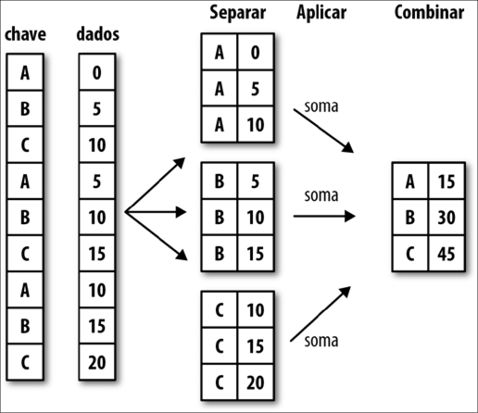

Retornando ao conjunto de dados anterior de gorjetas, suponha que
quiséssemos selecionar os cinco primeiros valores de *tip_pct* por
grupo. Inicialmente, escreva uma função que selecione as linhas
com os maiores valores em uma coluna em particular:

In [ ]:
def top(df, n=5, column='tip_pct'):
  return df.sort_values(by=column)[-n:]

In [ ]:
top(tips, n=6)

,total_bill,tip,sex,smoker,day,time,size,tip_pct
109,14.31,4.00,Female,Yes,Sat,Dinner,2,0.279525
183,23.17,6.50,Male,Yes,Sun,Dinner,4,0.280535
232,11.61,3.39,Male,No,Sat,Dinner,2,0.291990
67,3.07,1.00,Female,Yes,Sat,Dinner,1,0.325733
178,9.60,4.00,Female,Yes,Sun,Dinner,2,0.416667
172,7.25,5.15,Male,Yes,Sun,Dinner,2,0.710345


Se agruparmos de acordo com *smoker*, por exemplo, e chamarmos
*apply* com essa função, teremos o seguinte:

In [ ]:
tips.groupby('smoker').apply(top)

total_bill   tip     sex smoker   day    time  size   tip_pct
smoker                                                                   
No     88        24.71  5.85    Male     No  Thur   Lunch     2  0.236746
       185       20.69  5.00    Male     No   Sun  Dinner     5  0.241663
       51        10.29  2.60  Female     No   Sun  Dinner     2  0.252672
       149        7.51  2.00    Male     No  Thur   Lunch     2  0.266312
       232       11.61  3.39    Male     No   Sat  Dinner     2  0.291990
Yes    109       14.31  4.00  Female    Yes   Sat  Dinner     2  0.279525
       183       23.17  6.50    Male    Yes   Sun  Dinner     4  0.280535
       67         3.07  1.00  Female    Yes   Sat  Dinner     1  0.325733
       178        9.60  4.00  Female    Yes   Sun  Dinner     2  0.416667
       172        7.25  5.15    Male    Yes   Sun  Dinner     2  0.710345

O que aconteceu nesse caso? A função *top* é chamada em cada
grupo de linhas do DataFrame; então os resultados são unidos com
*pandas.concat*, atribuindo os nomes dos grupos como rótulos para
cada parte. Assim, o resultado tem um índice hierárquico cujo nível
mais interno contém valores de índice do DataFrame original.

Se você passar uma função para *apply* que aceite outros argumentos
ou argumentos nomeados, esses poderão ser passados depois da
função:

In [ ]:
tips.groupby(['smoker', 'day']).apply(top, n=1, column='total_bill')

total_bill    tip     sex smoker   day    time  size   tip_pct
smoker day                                                                     
No     Fri  94        22.75   3.25  Female     No   Fri  Dinner     2  0.142857
       Sat  212       48.33   9.00    Male     No   Sat  Dinner     4  0.186220
       Sun  156       48.17   5.00    Male     No   Sun  Dinner     6  0.103799
       Thur 142       41.19   5.00    Male     No  Thur   Lunch     5  0.121389
Yes    Fri  95        40.17   4.73    Male    Yes   Fri  Dinner     4  0.117750
       Sat  170       50.81  10.00    Male    Yes   Sat  Dinner     3  0.196812
       Sun  182       45.35   3.50    Male    Yes   Sun  Dinner     3  0.077178
       Thur 197       43.11   5.00  Female    Yes  Thur   Lunch     4  0.115982

OBS: *Para além desse uso básico, tirar o máximo de proveito de apply pode
exigir um pouco de criatividade. O que ocorre dentro da função passadapara esse método é de sua responsabilidade; ela só precisa devolver um
objeto do pandas ou um valor escalar. O restante deste capítulo consistirá
principalmente de exemplos que mostram como resolver diversos problemas
usando groupby.*

Talvez você se recorde de que chamei describe antes em um objeto
GroupBy:

In [ ]:
result = tips.groupby('smoker')['tip_pct'].describe()
result

,count,mean,std,min,25%,50%,75%,max
smoker,,,,,,,,
No,151.0,0.159328,0.039910,0.056797,0.136906,0.155625,0.185014,0.291990
Yes,93.0,0.163196,0.085119,0.035638,0.106771,0.153846,0.195059,0.710345


In [ ]:
result.unstack('smoker')

       smoker
count  No        151.000000
       Yes        93.000000
mean   No          0.159328
       Yes         0.163196
std    No          0.039910
       Yes         0.085119
min    No          0.056797
       Yes         0.035638
25%    No          0.136906
       Yes         0.106771
50%    No          0.155625
       Yes         0.153846
75%    No          0.185014
       Yes         0.195059
max    No          0.291990
       Yes         0.710345
dtype: float64

Em GroupBy, quando chamamos um método como describe , esseserá, na verdade, apenas um atalho para:
```python
f = lambda x: x.describe()
grouped.apply(f)
```

### Suprimindo as chaves de grupo
Nos exemplos anteriores, vemos que o objeto resultante tem um
índice hierárquico composto das chaves de grupo, junto com os
índices de cada parte do objeto original. Podemos desativar isso
passando *group_keys=False* para *groupby*:

In [ ]:
tips.groupby('smoker', group_keys=False).apply(top)

,total_bill,tip,sex,smoker,day,time,size,tip_pct
88,24.71,5.85,Male,No,Thur,Lunch,2,0.236746
185,20.69,5.00,Male,No,Sun,Dinner,5,0.241663
51,10.29,2.60,Female,No,Sun,Dinner,2,0.252672
149,7.51,2.00,Male,No,Thur,Lunch,2,0.266312
232,11.61,3.39,Male,No,Sat,Dinner,2,0.291990
109,14.31,4.00,Female,Yes,Sat,Dinner,2,0.279525
183,23.17,6.50,Male,Yes,Sun,Dinner,4,0.280535
67,3.07,1.00,Female,Yes,Sat,Dinner,1,0.325733
178,9.60,4.00,Female,Yes,Sun,Dinner,2,0.416667
172,7.25,5.15,Male,Yes,Sun,Dinner,2,0.710345


### Análise de quantis e de buckets
Como você deve se recordar, o pandas tem algumas
ferramentas, em particular *cut* e *qcut*, para fatiar dados em buckets,
com compartimentos (bins) de sua preferência, ou por quantis da
amostra. Combinar essas funções com *groupby* faz com que seja
conveniente realizar análises de buckets ou de quantis em um
conjunto de dados. Considere um conjunto de dados aleatório
simples e uma classificação em buckets de mesmo tamanho usando
*cut*:

In [ ]:
frame = pd.DataFrame({'data1': np.random.randn(1000),
                      'data2': np.random.randn(1000)})

In [ ]:
quartiles = pd.cut(frame.data1, 4)
quartiles[:10]

0    (-1.56, 0.297]
1    (-1.56, 0.297]
2    (0.297, 2.155]
3    (-1.56, 0.297]
4    (0.297, 2.155]
5    (0.297, 2.155]
6    (-1.56, 0.297]
7    (-1.56, 0.297]
8    (0.297, 2.155]
9    (-1.56, 0.297]
Name: data1, dtype: category
Categories (4, interval[float64]): [(-3.425, -1.56] < (-1.56, 0.297] < (0.297, 2.155] < (2.155, 4.012]]

O objeto *Categorical* devolvido por *cut* pode ser passado diretamente
para *groupby*. Assim, podemos calcular um conjunto de estatísticas
para a coluna *data2* da seguinte maneira:

In [ ]:
def get_stats(group):
  return {'min': group.min(), 'max': group.max(),
          'count': group.count(), 'mean': group.mean()}

In [ ]:
grouped = frame.data2.groupby(quartiles)

In [ ]:
grouped.apply(get_stats).unstack()

,min,max,count,mean
data1,,,,
"(-3.425, -1.56]",-2.587013,2.117989,58.0,-0.156643
"(-1.56, 0.297]",-3.076808,3.451721,568.0,-0.002696
"(0.297, 2.155]",-2.737186,2.771260,358.0,-0.019734
"(2.155, 4.012]",-1.021635,1.625239,16.0,0.393071


Esses buckets eram de mesmo tamanho; para calcular buckets de
mesmo tamanho em quantis da amostra, utilize *qcut*. Usarei
*labels=False* para obter somente os números dos quantis:

In [ ]:
grouping = pd.qcut(frame.data1, 10, labels=False)

In [ ]:
grouped = frame.data2.groupby(grouping)

In [ ]:
grouped.apply(get_stats).unstack()

,min,max,count,mean
data1,,,,
0,-2.801386,2.117989,100.0,-0.143164
1,-2.074796,2.707128,100.0,-0.017936
2,-1.955239,3.204893,100.0,0.055415
3,-2.436853,2.802529,100.0,-0.033154
4,-3.076808,2.549515,100.0,-0.027674
5,-2.969354,3.451721,100.0,-0.036274
6,-2.455824,2.179160,100.0,0.119092
7,-2.737186,2.771260,100.0,-0.007313
8,-2.444561,2.296565,100.0,-0.076089


### Exemplo: preenchendo valores ausentes com valores específicos de grupo
Ao limpar dados ausentes, em alguns casos, você substituirá os
dados observados usando *dropna*, porém, em outros, talvez você
queira representar valores nulos (NA), isto é, preenchê-los, com um
valor fixo ou outro valor derivado dos dados. *fillna* é a ferramenta
correta a ser usada; por exemplo, preencherei a seguir os valores
NA com a média:

In [ ]:
s = pd.Series(np.random.randn(6))

In [ ]:
s[::2] = np.nan

In [ ]:
s

0         NaN
1   -0.188934
2         NaN
3    0.450026
4         NaN
5   -1.042618
dtype: float64

In [ ]:
s.fillna(s.mean())

0   -0.260508
1   -0.188934
2   -0.260508
3    0.450026
4   -0.260508
5   -1.042618
dtype: float64

Suponha que seja necessário que o valor de preenchimento varie
conforme o grupo. Um modo de fazer isso é agrupar os dados e
usar *apply* com uma função que chame *fillna* em cada porção de
dados. Eis alguns dados de exemplo dos estados norte-americanos,
divididos em regiões leste e oeste:

In [ ]:
states = ['Ohio', 'New York', 'Vermont', 'Florida',
          'Oregon', 'Nevada', 'California', 'Idaho']

group_key = ['East'] * 4 + ['West'] * 4

In [ ]:
data = pd.Series(np.random.randn(8), index=states)
data

Ohio         -0.307520
New York     -0.096099
Vermont       0.905205
Florida      -1.254593
Oregon       -0.677624
Nevada        0.524788
California   -1.439452
Idaho        -0.480119
dtype: float64

Observe que a sintaxe *\['East'\]* \* 4 gera uma lista contendo quatro
cópias dos elementos em *\['East'\]*. Somar listas faz com que elassejam concatenadas.

Vamos definir alguns valores como ausentes nos dados:

In [ ]:
data[['Vermont', 'Nevada', 'Idaho']] = np.nan
data

Ohio         -0.307520
New York     -0.096099
Vermont            NaN
Florida      -1.254593
Oregon       -0.677624
Nevada             NaN
California   -1.439452
Idaho              NaN
dtype: float64

In [ ]:
data.groupby(group_key).mean()

East   -0.552737
West   -1.058538
dtype: float64

Podemos preencher os valores NA usando as médias dos grupos,
assim:

In [ ]:
fill_mean = lambda g: g.fillna(g.mean())
data.groupby(group_key).apply(fill_mean)

Ohio         -0.307520
New York     -0.096099
Vermont      -0.552737
Florida      -1.254593
Oregon       -0.677624
Nevada       -1.058538
California   -1.439452
Idaho        -1.058538
dtype: float64

Em outro caso, você pode ter valores de preenchimento
predefinidos em seu código, que variem conforme o grupo. Como osgrupos têm um atributo *name* definido internamente, podemos usá-lo:

In [ ]:
fill_values = {'East': 0.5, 'West': -1}

In [ ]:
fill_func = lambda g: g.fillna(fill_values[g.name])

In [ ]:
data.groupby(group_key).apply(fill_func)

Ohio         -0.307520
New York     -0.096099
Vermont       0.500000
Florida      -1.254593
Oregon       -0.677624
Nevada       -1.000000
California   -1.439452
Idaho        -1.000000
dtype: float64

### Exemplo: amostragem aleatória e permutação
Suponha que quiséssemos sortear uma amostra aleatória (com ou
sem substituição) a partir de um conjunto de dados grande, visando
a uma simulação de Monte Carlo ou outra aplicação. Há algumas
maneiras de fazer os “sorteios”; usaremos a seguir o método *sample*
de Series.

Para uma demonstração, eis uma forma de construir um baralho em
inglês:

In [ ]:
# Copas -> (C), Espada (E), Paus (P), Ouro (O)
suits = ['C', 'E', 'P', 'O']
card_val = (list(range(1, 11)) + [10] * 3) * 4
base_names = ['A'] + list(range(2, 11)) + ['J', 'K', 'Q']
cards = []

In [ ]:
for suit in suits:
  cards.extend(str(num) + suit for num in base_names)

In [ ]:
deck = pd.Series(card_val, index=cards)

Agora temos uma Series de tamanho 52 cujo índice contém os
nomes das cartas e os valores são aqueles usados no Blackjack
(Vinte e Um) e em outros jogos (para manter a simplicidade, deixareique o ás 'A' seja somente 1):

In [ ]:
deck[:13]

AC      1
2C      2
3C      3
4C      4
5C      5
6C      6
7C      7
8C      8
9C      9
10C    10
JC     10
KC     10
QC     10
dtype: int64

Com base no que dissemos antes, sortear uma mão de cinco cartas
do baralho poderia ser escrito da seguinte maneira:

In [ ]:
def draw(deck, n=5):
  return deck.sample(n)

In [ ]:
draw(deck)

4O      4
3O      3
AO      1
10O    10
JE     10
dtype: int64

Suponha que quiséssemos duas cartas aleatórias de cada naipe.
Como o naipe é o último caractere do nome de cada carta, podemos
fazer agrupamentos com base nisso e usar *apply*:

In [ ]:
get_suit = lambda card: card[-1] 

In [ ]:
deck.groupby(get_suit).apply(draw, n=2)

C  JC    10
   AC     1
E  8E     8
   QE    10
O  8O     8
   KO    10
P  KP    10
   QP    10
dtype: int64

De modo alternativo, poderíamos escrever:

In [ ]:
deck.groupby(get_suit, group_keys=False).apply(draw, n=2)

AC     1
4C     4
AE     1
9E     9
6O     6
3O     3
7P     7
KP    10
dtype: int64

Exemplo: média ponderada de grupos e correlação

No paradigma separar-aplicar-combinar (split-apply-combine) de
*groupby*, operações entre colunas em um DataFrame ou em duas
Series, como uma média ponderada de grupos, são possíveis.
Como exemplo, considere o conjunto de dados a seguir contendo
chaves de grupo, valores e alguns pesos:

In [ ]:
df = pd.DataFrame({'category': ['a', 'a', 'a', 'a', 'b', 'b', 'b', 'b'],
                   'data': np.random.randn(8),
                   'weights': np.random.randn(8)})
df

,category,data,weights
0,a,-0.881911,-0.749975
1,a,-1.981114,-0.144277
2,a,-0.597600,0.331825
3,a,-0.545123,-0.131496
4,b,-0.050463,0.210073
5,b,0.121737,-1.668285
6,b,0.391997,-0.000725
7,b,-0.446399,0.647271


A média ponderada dos grupos por *category* seria então:

In [ ]:
grouped = df.groupby('category')

In [ ]:
get_wavg = lambda g: np.average(g['data'], weights=g['weights'])

In [ ]:
grouped.apply(get_wavg)

category
a   -1.182586
b    0.619613
dtype: float64

Como outro exemplo, considere um conjunto de dados financeiros,
originalmente obtido do Yahoo! Finance, contendo os preços de
algumas ações no final do dia e o índice S&P 500 (o símbolo SPX ):

In [ ]:
path = '/content/drive/MyDrive/Análise de Dados/CSVs e TXTs/stock_px.csv'
close_px = pd.read_csv(path, parse_dates=True, index_col=0)

In [ ]:
close_px.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2214 entries, 2003-01-02 to 2011-10-14
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    2214 non-null   float64
 1   MSFT    2214 non-null   float64
 2   XOM     2214 non-null   float64
 3   SPX     2214 non-null   float64
dtypes: float64(4)
memory usage: 86.5 KB


In [ ]:
close_px[-4:]

,AAPL,MSFT,XOM,SPX
2011-10-11,400.29,27.00,76.27,1195.54
2011-10-12,402.19,26.96,77.16,1207.25
2011-10-13,408.43,27.18,76.37,1203.66
2011-10-14,422.00,27.27,78.11,1224.58


Uma tarefa interessante seria calcular um DataFrame constituído
das correlações anuais entre retornos diários (calculados a partir de
mudanças percentuais) e SPX. Como forma de fazer isso,
inicialmente criaremos uma função que calcule a correlação aos
pares entre cada coluna e a coluna *'SPX'*:

In [ ]:
spx_corr = lambda x: x.corrwith(x['SPX'])

Em seguida, calculamos as mudanças percentuais em *close_px*
usando *pct_change*:

In [ ]:
rets = close_px.pct_change().dropna()

Por fim, agrupamos essas mudanças percentuais por ano; esse
valor pode ser extraído de cada rótulo de linha com uma função de
uma linha que devolve o atributo *year* de cada rótulo *datetime*:

In [ ]:
get_year = lambda x: x.year
by_year = rets.groupby(get_year)

In [ ]:
by_year.apply(spx_corr)

,AAPL,MSFT,XOM,SPX
2003,0.541124,0.745174,0.661265,1.0
2004,0.374283,0.588531,0.557742,1.0
2005,0.467540,0.562374,0.631010,1.0
2006,0.428267,0.406126,0.518514,1.0
2007,0.508118,0.658770,0.786264,1.0
2008,0.681434,0.804626,0.828303,1.0
2009,0.707103,0.654902,0.797921,1.0
2010,0.710105,0.730118,0.839057,1.0
2011,0.691931,0.800996,0.859975,1.0


Também poderíamos calcular as correlações entre as colunas. A
seguir, calcularemos a correlação anual entre a Apple e a Microsoft:

In [ ]:
by_year.apply(lambda g: g['AAPL'].corr(g['MSFT']))

2003    0.480868
2004    0.259024
2005    0.300093
2006    0.161735
2007    0.417738
2008    0.611901
2009    0.432738
2010    0.571946
2011    0.581987
dtype: float64

### Exemplo: regressão linear nos grupos

Seguindo a mesma temática do exemplo anterior, podemos utilizar
*groupby* para realizar análises estatísticas mais complexas nos
grupos, desde que a função devolva um objeto do pandas ou um
valor escalar. Por exemplo, posso definir a função *regress* a seguir
(usando a biblioteca de econometria *statsmodels*), que executa uma
regressão OLS (Ordinary Least Squares, ou Mínimos Quadrados
Ordinários) em cada porção de dados:

In [ ]:
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def regress(data, yvar, xvars):
  Y = data[yvar]
  X = data[xvars]
  X['intercept'] = 1
  result = sm.OLS(Y, X).fit()
  return result.params

Para executar uma regressão linear anual de AAPL nos retornos de
SPX, execute:

In [ ]:
by_year.apply(regress, 'AAPL', ['SPX'])

,SPX,intercept
2003,1.195406,0.000710
2004,1.363463,0.004201
2005,1.766415,0.003246
2006,1.645496,0.000080
2007,1.198761,0.003438
2008,0.968016,-0.001110
2009,0.879103,0.002954
2010,1.052608,0.001261
2011,0.806605,0.001514


### Tabelas pivôs e tabulação cruzada

Uma *tabela pivô* é uma ferramenta de sintetização de dados
frequentemente encontrada em programas de planilhas e em outros
softwares de análise de dados. Ela agrega uma tabela de dados de
acordo com uma ou mais chaves, organizando os dados em um
retângulo com algumas das chaves de grupo nas linhas e outras nas
colunas. As tabelas pivôs em Python com pandas são possíveis por
meio do recurso *groupby* descrito neste capítulo, em conjunto com
operações de reformatação que utilizam indexação hierárquica. O
DataFrame tem um método *pivot_table*, e há também uma função
*pandas.pivot_table* de nível superior. Além de oferecer uma interface
conveniente para *groupby*, *pivot_table* pode somar totais parciais,
também conhecidos como *margens* (margins).

Voltando ao conjunto de dados de gorjetas, suponha que
quiséssemos calcular uma tabela de médias de grupos (o tipo de
agregação default de *pivot_table*), organizada por *day* e *smoker* nas
linhas:

In [ ]:
tips.pivot_table(index=['day', 'smoker'])

size       tip   tip_pct  total_bill
day  smoker                                          
Fri  No      2.250000  2.812500  0.151650   18.420000
     Yes     2.066667  2.714000  0.174783   16.813333
Sat  No      2.555556  3.102889  0.158048   19.661778
     Yes     2.476190  2.875476  0.147906   21.276667
Sun  No      2.929825  3.167895  0.160113   20.506667
     Yes     2.578947  3.516842  0.187250   24.120000
Thur No      2.488889  2.673778  0.160298   17.113111
     Yes     2.352941  3.030000  0.163863   19.190588

Esses dados poderiam ter sido gerados diretamente com *groupby*.
Suponha agora que quiséssemos agregar apenas *tip_pct* e *size*, e,
além disso, agrupar de acordo com *time*. Colocarei *smoker* nas colunas da tabela e *day* nas linhas:

In [ ]:
tips.pivot_table(['tip_pct', 'size'], index=['time', 'day'], columns='smoker')

size             tip_pct          
smoker             No       Yes        No       Yes
time   day                                         
Dinner Fri   2.000000  2.222222  0.139622  0.165347
       Sat   2.555556  2.476190  0.158048  0.147906
       Sun   2.929825  2.578947  0.160113  0.187250
       Thur  2.000000       NaN  0.159744       NaN
Lunch  Fri   3.000000  1.833333  0.187735  0.188937
       Thur  2.500000  2.352941  0.160311  0.163863

Poderíamos expandir essa tabela de modo que inclua totais
parciais, passando *margins=True*. Isso tem o efeito de adicionar
rótulos *All* para linhas e colunas, com os valores correspondentes
sendo as estatísticas de grupo para todos os dados em uma única
camada:

In [ ]:
tips.pivot_table(['tip_pct', 'size'], index=['time', 'day'], columns='smoker', margins=True)

size                       tip_pct                    
smoker             No       Yes       All        No       Yes       All
time   day                                                             
Dinner Fri   2.000000  2.222222  2.166667  0.139622  0.165347  0.158916
       Sat   2.555556  2.476190  2.517241  0.158048  0.147906  0.153152
       Sun   2.929825  2.578947  2.842105  0.160113  0.187250  0.166897
       Thur  2.000000       NaN  2.000000  0.159744       NaN  0.159744
Lunch  Fri   3.000000  1.833333  2.000000  0.187735  0.188937  0.188765
       Thur  2.500000  2.352941  2.459016  0.160311  0.163863  0.161301
All          2.668874  2.408602  2.569672  0.159328  0.163196  0.160803

Nesse exemplo, os valores de *All* são as médias, sem levar em
consideração os fumantes *versus* os não fumantes (as colunas de *All*)
nem qualquer um dos dois níveis de agrupamento nas linhas (a
linha *All*).

Para utilizar uma função de agregação diferente, passe-a para
*aggfunc*. Por exemplo, *'count'* ou *len* oferecerão uma tabulação cruzada (contador ou frequência) dos tamanhos dos grupos:

In [ ]:
tips.pivot_table('tip_pct', index=['time', 'smoker'], columns='day', aggfunc=len, margins=True)

day             Fri   Sat   Sun  Thur    All
time   smoker                               
Dinner No       3.0  45.0  57.0   1.0  106.0
       Yes      9.0  42.0  19.0   NaN   70.0
Lunch  No       1.0   NaN   NaN  44.0   45.0
       Yes      6.0   NaN   NaN  17.0   23.0
All            19.0  87.0  76.0  62.0  244.0

Se algumas combinações forem vazias (ou se forem NA), você
poderá passar um *fill_value*:

In [ ]:
tips.pivot_table('tip_pct', index=['time', 'size', 'smoker'],
                 columns='day', aggfunc='mean', fill_value=0)

day                      Fri       Sat       Sun      Thur
time   size smoker                                        
Dinner 1    No      0.000000  0.137931  0.000000  0.000000
            Yes     0.000000  0.325733  0.000000  0.000000
       2    No      0.139622  0.162705  0.168859  0.159744
            Yes     0.171297  0.148668  0.207893  0.000000
       3    No      0.000000  0.154661  0.152663  0.000000
            Yes     0.000000  0.144995  0.152660  0.000000
       4    No      0.000000  0.150096  0.148143  0.000000
            Yes     0.117750  0.124515  0.193370  0.000000
       5    No      0.000000  0.000000  0.206928  0.000000
            Yes     0.000000  0.106572  0.065660  0.000000
       6    No      0.000000  0.000000  0.103799  0.000000
Lunch  1    No      0.000000  0.000000  0.000000  0.181728
            Yes     0.223776  0.000000  0.000000  0.000000
       2    No      0.000000  0.000000  0.000000  0.166005
            Yes     0.181969  0.000000  0.000000  0.158843
       3    No      0.187735  0.000000  0.000000  0.084246
            Yes     0.000000  0.000000  0.000000  0.204952
       4    No      0.000000  0.000000  0.000000  0.138919
            Yes     0.000000  0.000000  0.000000  0.155410
       5    No      0.000000  0.000000  0.000000  0.121389
       6    No      0.000000  0.000000  0.000000  0.173706

### Tabela – Opções de pivot_table
Nome da função | Descrição
---------------|----------------------------
**values** | Nome ou nomes das colunas a serem agregadas; por padrão, agrega
|todas as colunas numéricas
**index** | Nomes das colunas ou outras chaves de grupo para agrupar nas
|linhas da tabela pivô resultante
**columns** | Nomes das colunas ou outras chaves de grupo para agrupar nas
|colunas da tabela pivô resultante
aggfunc** | Função de agregação ou lista de funções (o default é 'mean'); pode
|ser qualquer função válida no contexto de um groupby
**fill_value** | Substitui valores ausentes na tabela resultante
**dropna** | Se for True, não inclui as colunas cujas entradas sejam todas NA
***margins** | Adiciona subtotais para linhas/colunas e um total geral (o default é
|False)

### Tabulações cruzadas: crosstab
Uma tabulação cruzada (ou crosstab, em sua forma abreviada) é um
caso especial de uma tabela pivô que calcula frequências de
grupos.

In [ ]:
pd.crosstab([tips.time, tips.day], tips.smoker, margins=True)

smoker        No  Yes  All
time   day                
Dinner Fri     3    9   12
       Sat    45   42   87
       Sun    57   19   76
       Thur    1    0    1
Lunch  Fri     1    6    7
       Thur   44   17   61
All          151   93  244